In [173]:
#coding utf8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm


In [174]:
'''
Deprecated load data function
'''
def load_data():
    args = []
    prod_df = pd.read_csv('data\productivity.csv')
    prod_new_df = pd.read_csv('data\productivity_new.csv')
    sentiment_df = pd.read_csv('data\sentiment.csv')
    hours_worked_df = pd.read_csv('data\lfsa_ewhun2_1_Data.csv')
    productivity_df = pd.read_csv('./data/GDP_per_quarter.csv') 
    unem_df = pd.read_csv('./data/unem.csv')
    covid_df = pd.read_csv('./data/DataPerWeek.csv')
    unem_df.fillna(0)
    productivity_df.fillna(0)
    sentiment_df.fillna(0)
    prod_df.fillna(0)
    covid_df.fillna(0)
    args += [prod_df, sentiment_df, hours_worked_df, prod_new_df, productivity_df, unem_df, covid_df]
    return args


In [175]:
'''
Functions for loading in and combining data
'''
def load_df(file_name):
    '''
    Load a into a data frame that is quarterly from the Eurostat website
    '''
    df = pd.read_excel(file_name, sheet_name='Sheet 1')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(':', np.nan, inplace=True)
    df.index = df.iloc[:, 0]
    df.drop(df.columns[[0]], axis=1, inplace=True)
    for i in df.columns[:]:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce")
    df.interpolate(method='linear', inplace=True, axis = 1)
    df.sort_index(inplace=True)
    return df

def create_per_employeer(GDP_df, HW_df, employees_df):
    ''' 
    Inputs: GDP, hours worked, and employees dataframes
    Output: dataframe with per-employee GDP and per hour worked GDP
    '''
    cols =(list(set(GDP_df.columns) and set(employees_df.columns) and set(HW_df.columns)))
    cols.sort()
    idx = cols.pop()
    per_employee_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    per_HW_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    for i in cols:
        per_employee_df[i] = GDP_df[i]/employees_df[i]
        per_HW_df[i] = per_employee_df[i]/HW_df[i]
    return per_employee_df, per_HW_df

def country_code_to_name(df):
    '''
    Renames country codes to country names
    '''
    df = df.rename({'AUT': 'Austria', 'BEL': 'Belgium', 'DEU': 'Germany','EST': 'Estonia','FIN': 'Finland','ESP': 'Spain','FRA': 'France','GRC': 'Greece','IRL': 'Ireland','ITA': 'Italy','LTU': 'Lithuania','LUX': 'Luxembourg','LVA': 'Latvia','PRT': 'Portugal','NLD': 'Netherlands','SVK': 'Slovakia','SVN': 'Slovenia','ISL': 'Iceland','GBR': 'United Kingdom','CHE': 'Switzerland','CZE': 'Cezch Republic','DNK': 'Denmark','HUN': 'Hungary','NOR': 'Norway','POL': 'Poland','SWE': 'Sweden'})
    return df

def match_df(dfs):
    ''' 
    Input : dataframes
    This function matches dataframes by their index and column 
    Output: matched dataframes
    '''
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.intersection(set(i.index))
        cols = cols.intersection(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
    return dfs


In [176]:
'''
Functions for time series prediction
'''
def process_data(X, y, split_point, time_step, data_memory):
    '''
    Inputs: X, y, split_point, time_step, data_memory
    Splits data into training and testing data
    Outputs: X_train, X_test, y_train, y_test
    '''
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    split_point = int(X_norm.shape[0] *split_point)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    '''
    Inputs: X, y
    Normalises the data by subtracting the mean and dividing by the standard deviation
    Outputs : X_norm, y_norm, X_attrs, y_attrs
    '''
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5  
    return X, X_attrs, y, y_attrs

def train_test_split(X, y, split_point):
    '''
    Splits the data into training and testing data
    '''
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    '''
    Creates a model with the specified layers
    '''
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError()])
    if print_summary:
        model.summary()
    return model

def run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point):
    '''
    Inputs: X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point
    Runs the model on the data
    Outputs: model, history
    '''
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y, split_point, time_step, data_memory)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    y_pred_norm = np.roll(y_pred_norm, 1, axis = 1)
    y_pred = np.roll(y_pred_norm *y_attrs[:, 1]**0.5 + y_attrs[:, 0] , 0)
    mse = metrics.MeanSquaredError()
    mse.update_state(y_norm, y_pred_norm)
    test_loss = mse.result().numpy()
    print(test_loss)
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    model_performance = [time_step, data_memory, samples, epochs, batch_size, train_loss, val_loss, test_loss]
    df_model = pd.DataFrame(model_performance).transpose()
    df_model.to_csv('model_performance.csv', mode = 'a', header= False)
    return y, y_pred, history


<AxesSubplot:>

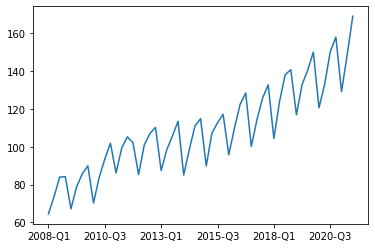

In [177]:
'''
Loads in gross domestic product, hours worked and employees data
Returns GDP per employee and GDP per hour worked
'''
GDP_df =  load_df('./data/GDP_per_quarter_2.xlsx') * 1e6
HW_df = load_df('./data/hours_worked.xlsx')
employees_df = load_df('./data/Employees.xlsx') * 1e3
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)


per_HW_df.iloc[4, :].T.plot(legend = False)




In [178]:
'''
Inflation data
'''
inf_df = pd.read_csv('data/Quarterly_infilation.csv')
inf_df =inf_df.drop(['SUBJECT', 'MEASURE','FREQUENCY','Flag Codes'], axis=1)
inf_df = inf_df.pivot_table('Value', ['LOCATION', 'INDICATOR'], 'TIME')
inf_df = country_code_to_name(inf_df)
inf_df = inf_df.reset_index('INDICATOR')
del inf_df['INDICATOR']

In [179]:
'''
Depression data
'''
dep_df = pd.read_csv('data/depression_by_age.csv') 
dep_df = dep_df.drop(['Prevalence - Depressive disorders - Sex: Both - Age: 10 to 14 (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: 70+ years (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)', 'Prevalence - Depressive disorders - Sex: Both - Age: 15-49 years (Percent)'],axis=1)
a = ['Belgium','Bulgaria','Denmark','Germany','Estonia','Ireland','Greece','Spain','France','Croatia','Italy','Cyprus','Latvia','Lithuania','Luxemburg','Hungary','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia','Slovakia','Finland','Sweden','Iceland','Norway','Switzerland','United Kingdom','Montenegro','North Macedonia','Serbia','Turkey']
dep_df = dep_df[dep_df['Entity'].isin(a)]
dep_df['Age:15-69_depression_average']=dep_df.iloc[:,3:7].mean(axis=1,skipna=True)
dep_df = dep_df.pivot_table('Age:15-69_depression_average', ['Entity', 'Code'], 'Year')
dep_df = dep_df.reset_index('Code')
del dep_df['Code']
dep_data = dep_df.to_numpy(dtype=np.float64)
dep_data = np.repeat(dep_data, 4, axis = 1)
dep_quarterly_df = pd.DataFrame(dep_data)
dep_quarterly_df.index = dep_df.index
dep_quarterly_df.columns = GDP_df.columns[60:180]

In [180]:
dfs = [per_HW_df, inf_df, per_employee_df, dep_quarterly_df]
matched_dfs = match_df(dfs)
matched_dfs[3].head()

,2008-Q1,2008-Q2,2008-Q3,2008-Q4,2009-Q1,2009-Q2,2009-Q3,2009-Q4,2010-Q1,2010-Q2,...,2017-Q3,2017-Q4,2018-Q1,2018-Q2,2018-Q3,2018-Q4,2019-Q1,2019-Q2,2019-Q3,2019-Q4
Entity,,,,,,,,,,,,,,,,,,,,,
Austria,3.932948,3.932948,3.932948,3.932948,3.894398,3.894398,3.894398,3.894398,3.874706,3.874706,...,3.904541,3.904541,3.909877,3.909877,3.909877,3.909877,3.919968,3.919968,3.919968,3.919968
Belgium,4.470518,4.470518,4.470518,4.470518,4.529200,4.529200,4.529200,4.529200,4.556212,4.556212,...,4.373711,4.373711,4.381408,4.381408,4.381408,4.381408,4.395594,4.395594,4.395594,4.395594
Denmark,4.109055,4.109055,4.109055,4.109055,4.084853,4.084853,4.084853,4.084853,4.071869,4.071869,...,4.056408,4.056408,4.068515,4.068515,4.068515,4.068515,4.097514,4.097514,4.097514,4.097514
Estonia,4.093089,4.093089,4.093089,4.093089,4.002988,4.002988,4.002988,4.002988,3.930319,3.930319,...,3.690929,3.690929,3.701515,3.701515,3.701515,3.701515,3.718065,3.718065,3.718065,3.718065
Finland,6.216123,6.216123,6.216123,6.216123,6.213358,6.213358,6.213358,6.213358,6.196769,6.196769,...,5.759037,5.759037,5.772166,5.772166,5.772166,5.772166,5.793236,5.793236,5.793236,5.793236


In [42]:
X = per_HW_df.to_numpy()[:, :]
y = np.array([per_HW_df.to_numpy()[0, :]]).T
print(X.shape, y.shape)

(38, 55) (55, 1)


In [11]:
time_step, data_memory, epochs, batch_size, split_point = 5, 5, 10, 1, 0.9

load_model_bool, load_model, save_model, save_fig = False, 'EU_model', 'EU_model', 'EU'
model_layer = [layers.Dense(8, activation= 'linear'),
                layers.LSTM(4,activation= 'sigmoid', dropout = 0.1, recurrent_dropout = 0.1, return_sequences=False),
                layers.Dense(8, activation='linear'),
                layers.Dense(1)]
print_summary = True
y, y_pred, history = run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (34, 5, 8)                448       
                                                                 
 lstm (LSTM)                 (34, 4)                   208       
                                                                 
 dense_1 (Dense)             (34, 8)                   40        
                                                                 
 dense_2 (Dense)             (34, 1)                   9         
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 3s 15ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/10
30/30 [=======================

InvalidArgumentError: Incompatible shapes: [38,1] vs. [55,1] [Op:SquaredDifference]